In [3]:
import aplpy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys

In [4]:
sys.path.insert(1, '/Users/hannahkoziol/Dropbox/Research/python_modules/plfit')
import plfit

In [7]:
from numpy.random import rand,seed

/Users/hannahkoziol/Dropbox/Research/python_modules/plfit/plfit/plfit.py:806: RuntimeWarning: invalid value encountered in power
  Ppl = lambda X: 1+C*(xmin/(1-alpha)*(X/xmin)**(1-alpha))
/Users/hannahkoziol/Dropbox/Research/python_modules/plfit/plfit/plfit.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1+float(n) / sum(log(x/xmin))


PYTHON plfit executed in 0.075075 seconds
xmin: 0.705961 n(>xmin): 209 alpha: 2.41012 +/- 0.0975403   Log-Likelihood: -212.613   ks: 0.024815 p(ks): 0.760564


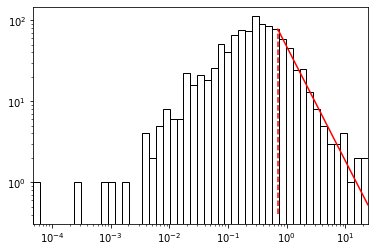

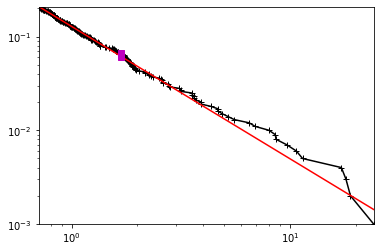

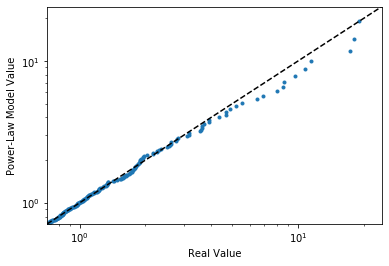

In [8]:
# generate a power law using the "inverse" power-law generator code
X=plfit.plexp_inv(rand(1000),1,2.5)
#X = np.linspace(0,10,100)
# use the numpy version to fit (usefortran=False is only needed if you installed the fortran version)
myplfit=plfit.plfit(X,usefortran=False)
# output should look something like this:
# PYTHON plfit executed in 0.201362 seconds
# xmin: 0.621393 n(>xmin): 263 alpha: 2.39465 +/- 0.0859979   Log-Likelihood: -238.959   ks: 0.0278864 p(ks): 0.986695
# generate some plots
from pylab import *
figure(1)
myplfit.plotpdf()
figure(2)
myplfit.plotcdf()
figure(3)
myplfit.plotppf()

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -8.470e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.174e-02 [aplpy.core]


Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


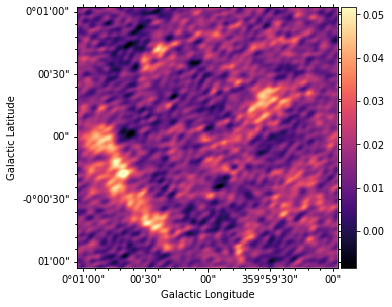

In [32]:
sim = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/feather10/feather10_B10_066_clean14_pbcor.fits')
fig = plt.figure(figsize=(5, 5))
subplot = aplpy.FITSFigure(sim, figure=fig, convention='calabretta')
subplot.show_colorscale(cmap='magma')
subplot.add_colorbar()

In [33]:
sim_array = sim[0].data
flat_sim_array = sim_array.flatten()

In [34]:
def Sr_conversion(bmaj, bmin):
    return ((np.pi * bmaj *bmin)/(4*np.log(2)))/((180/(np.pi))**2)

In [35]:
data, header = fits.getdata("/Users/hannahkoziol/Dropbox/Research/flux_trials/feather10/feather10_B10_066_clean14_pbcor.fits", header=True)
bmaj_sim = header['BMAJ']
bmin_sim = header['BMIN']

In [36]:
conversion = Sr_conversion(bmaj_sim, bmin_sim)
converted_array = sim_array / conversion

In [37]:
sim_header = header.copy()
sim_header['BUNIT'] = 'Jy/Sr'
fits.writeto('converted.fits', converted_array, sim_header, overwrite = True)

In [38]:
flux_sim = fits.open('converted.fits')
flux_data = flux_sim[0].data

In [39]:
distance        = 8178. # distance to GC; (GRAVITY collaboration 2019)
Wave            = (3.0e8/226.0e9) # define the wavelength from the SMA dust continuum frequency. 
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d # this kappa is the dust opacity, it's kind of complicated where it comes from, but if you're interested I can find you some stuff about it!
mu              = 2.8 # This mu is the mean atomic weight. 
hplanck = 6.626176e-34 #Joule seconds
clight = 3e8 #m/s
kboltzmann = 1.380649e-23 #Joule/Kelvin
mh = 1.6737236e-27

In [40]:
def planck_wave(Wave, Temp):
    planck_conv_wave = 1.e-26 *clight /Wave**2.0
    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave
    return planck

In [41]:
def column_density(Wave, Temp, Kappa, Flux_Density, mu):
    B = planck_wave(Wave, Temp)
    N = Flux_Density / (mu * (mh*1.e3) * Kappa * B)
    return N

In [42]:
column_density_array = column_density(Wave, 25, Kappa, flux_data, mu)
flat_column_density = column_density_array.flatten()

In [43]:
data, header = fits.getdata("/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits", header=True)
header2 = header.copy()
fits.writeto('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_066_clean14_pbcor.fits', column_density_array, header2, overwrite = True)

INFO: Auto-setting vmin to -4.693e+24 [aplpy.core]
INFO: Auto-setting vmax to  1.705e+26 [aplpy.core]


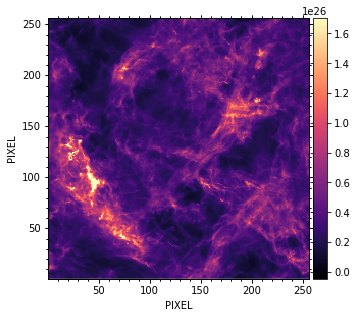

In [44]:
original_sim = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits')
fig = plt.figure(figsize=(5, 5))
subplot = aplpy.FITSFigure(original_sim, figure=fig, convention='calabretta')
subplot.show_colorscale(cmap='magma')
cmin, cmax = 23, 26
#nticks = 10
subplot.add_colorbar()

In [45]:
original_data = original_sim[0].data * 10 
#multiplying by 10 for every flux image that was multiplied by 10

column_density_array2 = original_data/(1e4)

In [46]:
data, header = fits.getdata("/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits", header=True)
header2 = header.copy()
fits.writeto('final2.fits', column_density_array2, header2, overwrite = True)

In [47]:
flat_column_density2 = column_density_array2.flatten()

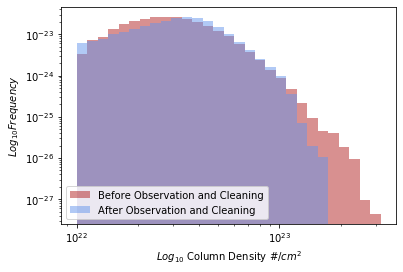

In [48]:
fig, ax = plt.subplots()
before_hist = plt.hist(flat_column_density2, bins=np.logspace(22, 23.5, 30), log=True, density = True, label = "Before Observation and Cleaning", color='firebrick', alpha=0.5)
after_hist = plt.hist(flat_column_density, bins=np.logspace(22, 23.5, 30), log=True, density = True, label = "After Observation and Cleaning", color='cornflowerblue', alpha=0.5)
ax.set_xscale('log')
plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
plt.ylabel('$Log_{10} Frequency$')
plt.legend(loc = 'lower left')
plt.show()

/Users/hannahkoziol/Dropbox/Research/python_modules/plfit/plfit/plfit.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1+float(n) / sum(log(x/xmin))


PYTHON plfit executed in 0.002010 seconds
Not enough data left after flagging low S/N points.  Using all data.
(PLFIT) Warning: finite-size bias may be present. n=30
xmin: 1e+22 n(>xmin): 30 alpha: 1.57906 +/- 0.105721   Log-Likelihood: -1617.9   ks: 0.165021 p(ks): 0.175135


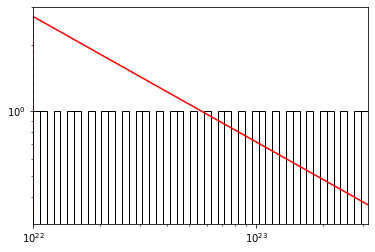

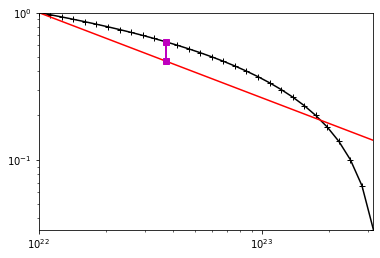

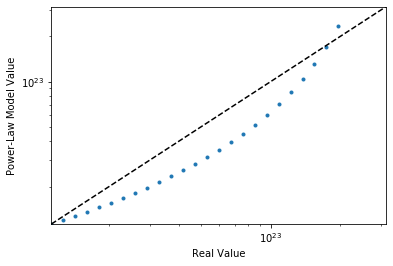

In [49]:
# use the numpy version to fit (usefortran=False is only needed if you installed the fortran version)
myplfit=plfit.plfit(before_hist[1],usefortran=False)
# output should look something like this:
# PYTHON plfit executed in 0.201362 seconds
# xmin: 0.621393 n(>xmin): 263 alpha: 2.39465 +/- 0.0859979   Log-Likelihood: -238.959   ks: 0.0278864 p(ks): 0.986695
# generate some plots
from pylab import *
figure(1)
myplfit.plotpdf()
figure(2)
myplfit.plotcdf()
figure(3)
myplfit.plotppf()

In [86]:
sigma = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_000_clean14_1_noise_finalfwhm.fits')
sigma_data = sigma[0].data
flat_sigma_data = sigma_data.flatten()
sigma_value = np.median(flat_sigma_data)
three_sigma_value = 3 * np.median(flat_sigma_data)

In [87]:
before_x = before_hist[1]
before_mid = [(a + b) /2 for a,b in zip(before_x[:-1], before_x[1:])]
before_y = before_hist[0]

In [88]:
x = np.array(before_mid)
y = np.array(before_y)

In [89]:
x_log_data = np.log(x[0:-1])
y_log_data = np.log(y[0:-1])

In [90]:
def resid_log(avec, x, y):
    ux = 1e-23*x
    B, A, Mu, Sigma, Alpha, Nu = avec
    R = np.zeros_like(x)
    cond1 = np.where(ux<B)
    cond2 = np.where(ux>B)
    R[cond1] = np.log(A) + (-((ux[cond1]-Mu)**2)/(2 * Sigma**2)) - y[cond1]
    R[cond2] = (Alpha) + (Nu * ux[cond2]) - y[cond2]
    if np.log(A) + (-((B-Mu)**2)/(2 * Sigma**2)) == (Alpha) + (Nu * B):
        R = 0
    return R

In [91]:
B, A, Mu, Sigma, Alpha, Nu = (5.01643155e+22 * 1e-23), 1, 0.4, 0.1, 10, -5
afit, flag = optimize.leastsq(resid_log, [B, A, Mu, Sigma, Alpha, Nu], args=(x[0:-1], y_log_data))
print(flag)
print(afit)

3
[ 5.01643155e-01  3.54179479e-23  3.35938408e-01  9.97872504e-02
 -5.03969195e+01 -5.12421480e+00]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [92]:
def fit(afit, x):
    yfit = np.zeros_like(x)
    cond1 = np.where(x<afit[0])
    cond2 = np.where(x>=afit[0])
    yfit[cond1] = np.log(afit[1]) + (-((x[cond1]-afit[2])**2)/(2 * afit[3]**2))
    yfit[cond2] = (afit[4]) + (afit[5] * x[cond2])
    return yfit

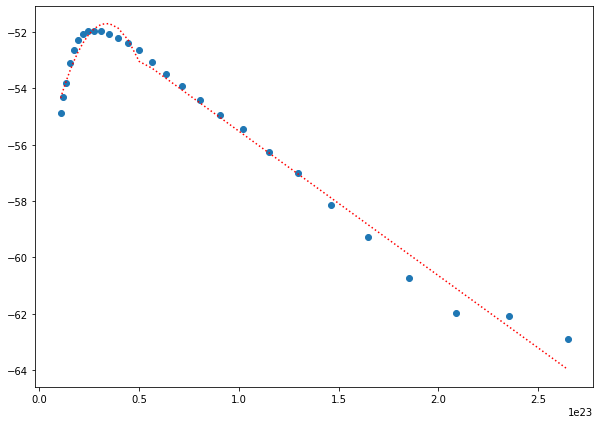

In [93]:
fig, ax = plt.subplots()
ax.scatter(x[:-1], (y_log_data))
ax.plot(x[:-1], (fit(afit, 1e-23*x[:-1])), color = 'red', linestyle = ':')
fig.set_size_inches(10,7)

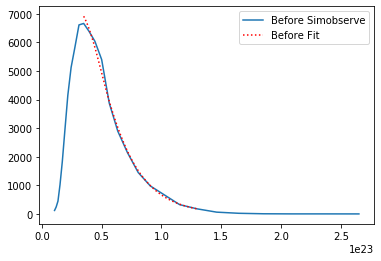

In [83]:
spl = UnivariateSpline(x[10:22], np.log(y[10:22]), k = 2, s = .03)
x_num_array = np.linspace(min(x[10:22]), max(x[10:22]), 500)
deriv = spl.derivative(1)
deriv2 = spl.derivative(2)

plt.plot(x[0:-1], y[0:-1], label = 'Before Simobserve' )
plt.plot(x_num_array, np.exp(spl(x_num_array)), label = 'Before Fit', linestyle = ':', color = 'red')
plt.legend()
plt.show()

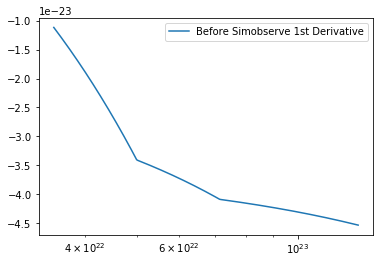

In [84]:
plt.plot(x_num_array, deriv(x_num_array), label = 'Before Simobserve 1st Derivative')
plt.xscale('log')
plt.legend()
plt.show()

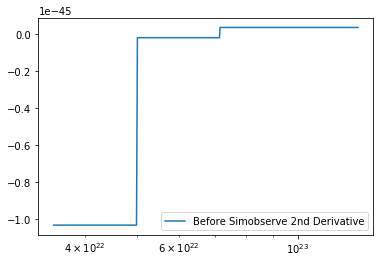

In [31]:
plt.plot(x_num_array, deriv2(x_num_array), label = 'Before Simobserve 2nd Derivative')
plt.xscale('log')
plt.legend()
plt.show()

In [33]:
print(deriv2(x_num_array))

[-1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45 -1.03226141e-45
 -1.03226141e-45 -1.03226

In [70]:
x_num_array[np.argwhere(deriv2(x_num_array) > -1.97795111e-47)]

array([[5.01643155e+22],
       [5.03540658e+22],
       [5.05438162e+22],
       [5.07335665e+22],
       [5.09233169e+22],
       [5.11130673e+22],
       [5.13028176e+22],
       [5.14925680e+22],
       [5.16823183e+22],
       [5.18720687e+22],
       [5.20618190e+22],
       [5.22515694e+22],
       [5.24413197e+22],
       [5.26310701e+22],
       [5.28208204e+22],
       [5.30105708e+22],
       [5.32003211e+22],
       [5.33900715e+22],
       [5.35798218e+22],
       [5.37695722e+22],
       [5.39593225e+22],
       [5.41490729e+22],
       [5.43388232e+22],
       [5.45285736e+22],
       [5.47183239e+22],
       [5.49080743e+22],
       [5.50978246e+22],
       [5.52875750e+22],
       [5.54773253e+22],
       [5.56670757e+22],
       [5.58568260e+22],
       [5.60465764e+22],
       [5.62363267e+22],
       [5.64260771e+22],
       [5.66158274e+22],
       [5.68055778e+22],
       [5.69953281e+22],
       [5.71850785e+22],
       [5.73748289e+22],
       [5.75645792e+22],


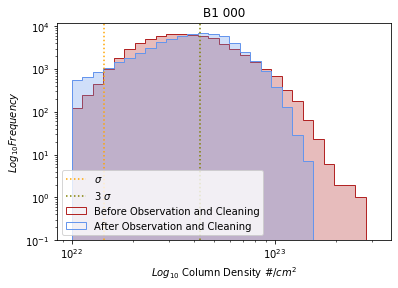

In [73]:
fig, ax = plt.subplots()
plt.hist(flat_column_density2, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "Before Observation and Cleaning", color='firebrick', alpha=0.99)
before_hist = plt.hist(flat_column_density2, bins=np.logspace(22, 23.5, 30), log=True, color='firebrick', alpha=0.3)
plt.hist(flat_column_density, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "After Observation and Cleaning", color='cornflowerblue', alpha=0.99)
after_hist = plt.hist(flat_column_density, bins=np.logspace(22, 23.5, 30), log=True, color='cornflowerblue', alpha=0.3)
plt.axvline(x = sigma_value, label = r'$\sigma$', linestyle = ':', color = 'orange')
plt.axvline(x = three_sigma_value, label = r'3 $\sigma$', linestyle = ':', color = 'olive')
ax.set_xscale('log')
plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
plt.ylabel('$Log_{10} Frequency$')
ax.set_title('B1 000')
plt.legend(loc = 'lower left')
plt.show()

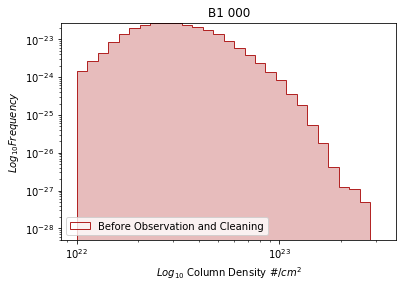

In [114]:
fig, ax = plt.subplots()
plt.hist(flat_column_density2, bins=np.logspace(22, 23.5, 30), histtype = 'step', density = True, log=True, label = "Before Observation and Cleaning", color='firebrick', alpha=0.99)
plt.hist(flat_column_density2, bins=np.logspace(22, 23.5, 30), density = True, log=True, color='firebrick', alpha=0.3)
#plt.hist(flat_column_density, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "After Observation and Cleaning", color='cornflowerblue', alpha=0.99)
#after_hist = plt.hist(flat_column_density, bins=np.logspace(22, 23.5, 30), log=True, color='cornflowerblue', alpha=0.3)
#plt.axvline(x = sigma_value, label = r'$\sigma$', linestyle = ':', color = 'orange')
#plt.axvline(x = three_sigma_value, label = r'3 $\sigma$', linestyle = ':', color = 'olive')
ax.plot(x[:-1], 1e-23*((fit(afit, 1e-23*x[:-1]))), color = 'blue', linestyle = ':')
ax.set_xscale('log')
plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
plt.ylabel('$Log_{10} Frequency$')
ax.set_title('B1 000')
plt.legend(loc = 'lower left')
plt.show()

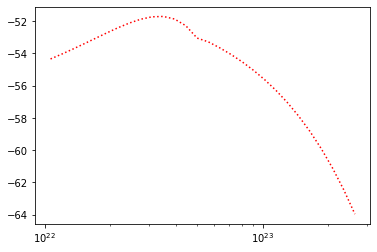

In [115]:
fig, ax = plt.subplots()
ax.plot(x[:-1], ((fit(afit, 1e-23*x[:-1]))), color = 'red', linestyle = ':')
ax.set_xscale('log')